# Семинар 2. Динамическое программирование. Монте-Карло и Временные различия

Мы рассмотрим несколько способов вычисления функций полезности и стратегии в модельном и безмодельном подходах.
В этом семинаре подробнее разберемся в функциях полезности и как их можно получить.

## Содержание:

1. [Теоретическое напоминание](#theory)
2. [Итерации по стратегиям](#pi)
3. [Итерации по полезностям](#vi)
4. [Монте-Карло оценка](#mc)
5. [Временные различия](#td)

In [ ]:
# @title Импортирование зависимостей, реализация MDP и среды FrozenLake

from IPython.display import HTML
from IPython.display import clear_output
from time import sleep

# most of this code was politely stolen from https://github.com/berkeleydeeprlcourse/homework/
# all creadit goes to https://github.com/abhishekunique (if i got the author right)
import sys
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle
%matplotlib inline

def weighted_choice(v, p):
   total = sum(p)
   r = random.uniform(0, total)
   upto = 0
   for c, w in zip(v,p):
      if upto + w >= r:
         return c
      upto += w
   assert False, "Shouldn't get here"

class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.

        States and actions can be anything you can use as dict keys, but we recommend that you use strings or integers

        Here's an example from MDP depicted on http://bit.ly/2jrNHNr
        transition_probs = {
              's0':{
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
              },
              's1':{
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
              },
              's2':{
                'a0': {'s0': 0.4, 's1': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
              }
            }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = random.choice(tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError("initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = weighted_choice(possible_states, p=probs)
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), "transition_probs for %s should be a dictionary " \
                                                              "but is instead %s" % (
                                                              state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), "transition_probs for %s, %s should be a " \
                                                                          "a dictionary but is instead %s" % (
                                                                              state, action,
                                                                              type(transition_probs[state, action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, "next state probabilities for state %s action %s " \
                                                    "add up to %f (should be 1)" % (state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), "rewards for %s should be a dictionary " \
                                                     "but is instead %s" % (state, type(transition_probs[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), "rewards for %s, %s should be a " \
                                                                 "a dictionary but is instead %s" % (
                                                                 state, action, type(transition_probs[state, action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance. "
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg

class FrozenLakeEnv(MDP):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    MAPS = {
        "4x4": [
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
        ],
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ],
    }


    def __init__(self, desc=None, map_name="4x4", slip_chance=0.2):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = self.MAPS[map_name]
        assert ''.join(desc).count('S') == 1, "this implementation supports having exactly one initial state"
        assert all(c in "SFHG" for c in ''.join(desc)), "all cells must be either of S, F, H or G"

        self.desc = desc = np.asarray(list(map(list,desc)),dtype='str')
        self.lastaction = None

        nrow, ncol = desc.shape
        states = [(i, j) for i in range(nrow) for j in range(ncol)]
        actions = ["left", "down", "right", "up"]

        initial_state = states[np.array(desc == 'S').ravel().argmax()]

        def move(row, col, movement):
            if movement== 'left':
                col = max(col-1,0)
            elif movement== 'down':
                row = min(row+1,nrow-1)
            elif movement== 'right':
                col = min(col+1,ncol-1)
            elif movement== 'up':
                row = max(row-1,0)
            else:
                raise("invalid action")
            return (row, col)

        transition_probs = {s : {} for s in states}
        rewards = {s : {} for s in states}
        for (row, col) in states:
            if desc[row, col]  in "GH": continue
            for action_i in range(len(actions)):
                action = actions[action_i]
                transition_probs[(row, col)][action] = {}
                rewards[(row, col)][action] = {}
                for movement_i in [(action_i - 1) % len(actions), action_i, (action_i + 1) % len(actions)]:
                    movement = actions[movement_i]
                    newrow, newcol = move(row, col, movement)
                    prob = (1. - slip_chance) if movement == action else (slip_chance / 2.)
                    if prob == 0: continue
                    if (newrow, newcol) not in transition_probs[row,col][action]:
                        transition_probs[row,col][action][newrow, newcol] = prob
                    else:
                        transition_probs[row, col][action][newrow, newcol] += prob
                    if desc[newrow, newcol] == 'G':
                        rewards[row,col][action][newrow, newcol] = 1.0

        MDP.__init__(self, transition_probs, rewards, initial_state)

    def _render_base(self, fig, ax):
        desc_copy = np.copy(self.desc)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_facecolor('#dde5f4')
        h, w = desc_copy.shape
        for i in range(h):
            for j in range(w):
                cell = desc_copy[i, j]
                if cell == 'H':
                    fancy = FancyBboxPatch(
                        (j+0.15, h-i-0.85), 0.7, 0.7, fc='#2389da', ec='#2389da',
                        boxstyle="round,pad=0.1,rounding_size=0.3"
                    )
                    ax.add_patch(fancy)
                if cell == 'G':
                    goal = Circle((j+0.5, h-i-0.5), 0.3, color='green')
                    ax.add_patch(goal)
        ax.set_xlim(0, w)
        ax.set_ylim(0, h)

    def render(self):
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        i, j = self._current_state
        ax.text(
            j+0.5, h-i-0.5, 'A', color='red', size='xx-large',
            horizontalalignment='center', verticalalignment='center'
        )
        plt.show()
        plt.close(fig)

    def render_policy(self, policy):
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        a2uv = {
            'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)
        }

        for i in range(h):
            for j in range(w):
                for a in self.get_possible_actions((i, j)):
                    pi = policy[(i, j)][a]
                    if a is None: continue
                    u, v = a2uv[a]
                    ax.arrow(j+0.5, h-i-0.5, 0.5 * pi * u, 0.5 * v * pi,
                      color='m', head_width=0.1,
                      head_length=0.1)
        plt.show()
        plt.close(fig)

    def render_det_policy(self, policy):
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        a2uv = {
            'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)
        }

        for i in range(h):
            for j in range(w):
                if (i, j) in policy:
                    a = policy[(i, j)]
                    u, v = a2uv[a]
                    ax.arrow(
                        j+0.5, h-i-0.5, 0.45 * u, 0.45 * v, color='m',
                        head_width=0.1, head_length=0.1
                    )
        plt.show()
        plt.close(fig)

    def render_trajs(self, trajectories):
        cmap = mpl.colormaps['inferno']
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        a2uv = {
            'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)
        }
        rets = [ret for _, ret in trajectories]
        max_ret = max(rets)
        min_ret = min(rets)
        delta = max_ret - min_ret

        for traj in trajectories:
            sa, ret = traj
            if delta == 0:
                ret = 1
            else:
                ret = (ret - min_ret) / (max_ret - min_ret)
            for s, a in sa:
                i, j = s
                u, v = a2uv[a]
                ax.arrow(
                    j + 0.5, h - i - 0.5, 0.4 * u, 0.4 * v, alpha=0.1,
                    color=cmap(ret), head_width=0.1, head_length=0.1
                )

        plt.show()
        plt.close(fig)

    def run_interactive(self):
        s = self.reset()
        for t in range(100):
            clear_output()
            self.render()
            print('Action: a - left; w - up, d - right, s - down')
            a = ''
            while a not in ['a', 'w', 'd', 's']:
                a = input()
            if a == 'a':
                a = 'left'
            elif a == 'w':
                a = 'up'
            elif a == 'd':
                a = 'right'
            elif a == 's':
                a = 'down'
            s, r, done, _ = self.step(a)
            if done:
                clear_output()
                self.render()
                break

# 1. Теоретическая шпаргалка <a name = 'theory'></a>

**Суммарное вознаграждение (отдача)** — сумма дисконтированных вознаграждений с момента времени $t$:

$$ R_t = r_{t+1} + \gamma r_{t+2} + \dots = \sum_{k=0}^∞ \gamma^k r_{t+k+1}.$$

**Функция полезности состояний $V^\pi(s)$** — математическое ожидание отдачи, полученной, начиная с состояния $s$, при выполнении стратегии $\pi$:

$$V^\pi(s) = \mathbb{E}_\pi[R_t|s_t=s].$$

**Функция полезности действий $Q^\pi(s, a)$** — математическое ожидание отдачи, полученной, начиная с состояния $s$ и выбранного действия $a$, при выполнении стратегии $\pi$:

$$Q^\pi(s, a) = \mathbb{E}_\pi[R_t|s_t=s, a_t=a].$$

**Связь функций полезности**:

$$V^\pi(s)=\sum_{a \in A} \pi(a|s) Q^\pi(s, a)$$

**Уравнение Беллмана**:

$$V^\pi(s) = \mathbb{E}_\pi[r_{t+1} + \gamma V(s_{t+1})|s_t=s]$$

$$Q^\pi(s, a) = \mathbb{E}_\pi[r_{t+1} + \gamma Q^\pi(s_{t+1}, a_{t+1})|s_t=s, a_t=a]$$

Подробнее:

$$V^\pi(s) = \sum_{a \in A} \pi(a|s)(r_s^a + \gamma \sum_{s' \in S} P_{ss'}^a V(s'))$$

$$Q^\pi(s) = r_s^a + \gamma \sum_{s' \in S} P_{ss'}^a  \sum_{a' \in A} \pi(a'|s') Q(s', a')$$

Матричная форма:

$$V^\pi = r^\pi + \gamma P^\pi V^\pi$$

$$V^\pi = (1 - \gamma P^\pi)^{-1}r^\pi$$


# 2. Итерации по стратегиям <a name = 'pi'></a>



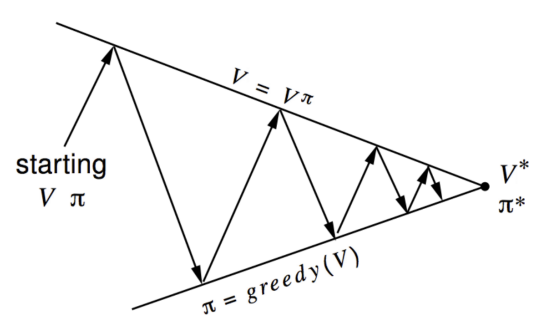

Рассмотрим алгоритм итерации по стратегиям (PI, policy iteration):

---
Initialize $\pi_0$   `// случайно`

For $n=0, 1, 2, \dots$
- Считаем функцию $V^{\pi_{n}}$
- Используя $V^{\pi_{n}}$, считаем функцию $Q^{\pi_{n}}$
- Получаем новую стратегию: $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

PI включает в себя оценку полезности состояния, как внутренний шаг. Вначале оценим полезности, используя текущую стратегию:

$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ r(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Мы будем искать точное решение, но можно использовать и итерационный подход, как будет разобрано [далее](#vi). Для этого будем решать систему линейных уравнений относительно $V^{\pi}(s)$ с помощью ``np.linalg.solve``. Решаем аналитически линейное матричное уравнение:

$$(1 - \gamma P^\pi) V^\pi = r^\pi.$$

In [ ]:
def compute_vpi(mdp, policy, gamma):
    """
    Считаем V^pi(s) для всех состояний, согласно стратегии.
    :param policy: словарь состояние->действие {s : a}
    :returns: словарь {state : V^pi(state)}
    """
    states = mdp.get_all_states()
    # Будем решать уравнение вида Ax = b
    A, b = [], []
    for i, state in enumerate(states):
        if state in policy:
            a = policy[state]
            A.append([(
                1 - gamma * mdp.get_transition_prob(state, a, next_state)
                if i == j
                else - gamma * mdp.get_transition_prob(state, a, next_state)
            ) for j, next_state in enumerate(states)])
            b.append(sum([
                prob * mdp.get_reward(state, a, next_state)
                for next_state, prob in mdp.get_next_states(state, a).items()
            ]))

        else:
            A.append([(1 if i == j else 0) for j, s in enumerate(states)])
            b.append(0)

    A = np.array(A)
    b = np.array(b)
    values = np.linalg.solve(A, b)
    state_values = {
        states[i] : values[i] for i in range(len(states))
    }
    return state_values

Давайте посмотрим на функцию полезности для агента со случайной стратегией со средой ``FrozenLake``.

In [ ]:
env = FrozenLakeEnv(slip_chance=0, map_name='4x4')
policy = {}
for s in env.get_all_states():
    if env.get_possible_actions(s):
        policy[s] = np.random.choice(env.get_possible_actions(s))
env.render_det_policy(policy)

In [ ]:
gamma = 0.9
field = np.zeros((4, 4))
for s, v in compute_vpi(env, policy, gamma).items():
    field[s] = v
plt.axis('off')
plt.imshow(field)
plt.colorbar()
plt.show()
plt.close()

Теперь мы можем обновить стратегию по полученной функции полезности. Для этого нам необходимо найти функцию полезности действий:

$$Q^{\pi}(s, a) = \sum_{s'} P(s, a ,s')[ R(s, a,s') + \gamma V^{\pi}(s')].$$

И жадно обновить стратегию:

$$\pi_{n+1}(s) = \text{argmax}_a Q^{\pi_n}(s, a).$$

In [ ]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Рассчитываем новую стратегию
    :param vpi: словарь {state : V^pi(state) }
    :returns: словарь {state : оптимальное действие}
    """
    Q = {}
    for state in mdp.get_all_states():
        Q[state] = {}
        for a in mdp.get_possible_actions(state):
            values = []
            for next_state in mdp.get_next_states(state, a):
                r = mdp.get_reward(state, a, next_state)
                p = mdp.get_transition_prob(state, a, next_state)
                # values.append(...)
                ####### Здесь ваш код ########

                ##############################

            Q[state][a] = sum(values)

    policy = {}
    for state in mdp.get_all_states():
        actions = mdp.get_possible_actions(state)
        if actions:
            # выбираем оптимальное действие в state
            # policy[state] = ...
            ####### Здесь ваш код ########

            ##############################

    return policy

Объединим оценку полезности и обновление стратегии в один цикл — итераций по стратегиям:

In [ ]:
value = compute_vpi(env, policy, gamma)
policy = compute_new_policy(env, value, gamma)

In [ ]:
gamma = 0.9
for i in range(10):
    value = compute_vpi(env, policy, gamma)
    policy = compute_new_policy(env, value, gamma)
    print(f"--------- Step {i} ---------")
    image = np.zeros((4, 4))
    for s, v in value.items():
        image[s] = v
    plt.figure(figsize=(4, 3))
    plt.axis('off')
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    plt.close()
    env.render_det_policy(policy)

## Теперь посмотрим на МППР:
<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/02/mdp.png" caption="Марковский процесс принятия решений" style="width: 200px;">

На картинке отображено все необходимое, вероятности переходов, функция вознаграждения, состояния и действия.

Зададим этот МППР с помощью привычного уже класса [``MDP``](#scrollTo=Ur4FAAIb5zWu&line=1&uniqifier=1), на котором основывался ``FrozenLake``.

In [ ]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's2': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

In [ ]:
print("all_states =", mdp.get_all_states())
print("possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

Проведем итерации по стратегиям для этого MDP.

In [ ]:
gamma = 0.9
policy = {
    s: np.random.choice(mdp.get_possible_actions(s))
    for s in mdp.get_all_states()}

for _ in range(5):
    new_vpi = compute_vpi(mdp, policy, gamma)
    print('value:', new_vpi)
    policy = compute_new_policy(mdp, new_vpi, gamma)
print('policy:', policy)

# 3. Итерации по полезностям <a name = 'vi'></a>

Теперь реализуем алгоритм итерации по полезностям. Псевдокод алгоритма:

---

`1.` Инициализируем $V^{(0)}(s)=0$, для всех $s$

`2.` For $i=0, 1, 2, \dots$

`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Вначале вычисляем оценку состояния-действия:
$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

In [ ]:
def get_action_value(
        mdp, state_values, state, action, gamma
    ):
    """ Вычислеям Q(s,a) по формуле выше """
    # Q =
    ####### Здесь ваш код ########

    ##############################
    return Q

In [ ]:
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Теперь оцениваем полезность самого состояния, для этого мы можем использовать предыдущий метод:

$$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [ ]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Считаем следующее V(s) по формуле выше."""
    if mdp.is_terminal(state):
        return 0
    # V =
    ####### Здесь ваш код ########

    ##############################
    V = max(v)
    return V

In [ ]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
   "Убедитесь, что вы правильно обрабатываете отрицательные значения Q произвольной величины."
assert test_Vs == test_Vs_copy, "Убедитесь, что вы не изменяете state_values в функции get_new_state_value"

Теперь создаем основной цикл итерационного оценки полезности состояний с критерием остановки, который проверяет насколько изменились полезности.

In [ ]:
def value_iteration(
        mdp, state_values=None, gamma = 0.9, num_iter = 1000,
        min_difference = 1e-5
    ):
    """ выполняет num_iter шагов итерации по значениям"""
    # инициализируем V(s)
    state_values = state_values or \
    {s : 0 for s in mdp.get_all_states()}

    for i in range(num_iter):
        new_state_values = {
            s : get_new_state_value(mdp, state_values, s, gamma)
            for s in mdp.get_all_states()
        }

        # Считаем разницу
        diff =  max(abs(
            new_state_values[s] - state_values[s]
        ) for s in mdp.get_all_states())

        print("iter %4i | diff: %6.5f | V(start): %.3f "%
          (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            print("Принято! Алгоритм сходится!")
            break

    return state_values

state_values = value_iteration(
    mdp, num_iter = 100, min_difference = 0.001
)

In [ ]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

По найденным полезностям и зная модель переходов легко найти оптимальную стратегию:
$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

In [ ]:
def get_optimal_action(
        mdp, state_values, state, gamma=0.9
    ):
    """ Находим оптимальное действие, используя формулу выше. """
    if mdp.is_terminal(state): return None

    actions = mdp.get_possible_actions(state)
    i = np.argmax([
        get_action_value(mdp, state_values, state, action, gamma)
        for action in actions
    ])
    return actions[i]

Теперь посмотрим как работает VI на ``FrozenLake``.

In [ ]:
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}
gamma = 0.9
for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(
        mdp, state_values, gamma, num_iter=1
    )
    policy = {}
    for s in mdp.get_all_states():
        if mdp.get_possible_actions(s):
            policy[s] = get_optimal_action(mdp, state_values, s, gamma)
    mdp.render_det_policy(policy)
    sleep(0.5)

# **Безмодельные подходы**

# 4. Монте-карло  <a name = 'mc'></a>

Теперь рассмотрим безмодельный подход. В данном случае у нас нет доступа к модели динамики среды. Будем оценивать функцию полезности как эмпирическое среднее:

$$V^\pi(s) = \mathbb{E}_\pi[R_t|s_t=s] \approx \frac{\sum^{N(s)} R(s)}{N(s)}.$$

$$V^\pi(s) \leftarrow V^\pi(s) + \alpha (R(s) - V^\pi(s)).$$

**Замечание!**

Данный метод требует эпизодических сред, то есть должно существовать терминальное состояние. Это обусловлено тем, что мы оцениваем функцию полезности через отдачу, для вычисления которой нужен весь эпизод.

In [ ]:
def collect_trajectory(env, policy, time_limit=100):
    sar = list()
    s = env.reset()
    for t in range(time_limit):
        pi = policy[s]
        acts = sorted(pi.keys())
        act_probs = [pi[a] for a in acts]
        a = np.random.choice(acts, p=act_probs)
        n_s, r, done, _ = env.step(a)
        sar.append([s, a, r])
        s = n_s
        if done:
            break
    return sar

In [ ]:
env = FrozenLakeEnv(slip_chance=0, map_name='4x4')
policy = {
    state: {
        action: 1 / len(env.get_possible_actions(state))
        for action in env.get_possible_actions(state)
    } for state in env.get_all_states()
}
env.render_policy(policy)

trajs = [collect_trajectory(env, policy) for _ in range(100)]
state_values = {
    state: 0 for state in env.get_all_states()
}

Будем искать функцию полезности состояний методом Монте-Карло с каждым посещением, то есть мы делаем обновление для состояний даже, если уже посещали это состояние ранее в эпизоде.

In [ ]:
def monte_carlo_value(trajs, state_values, gamma, lr):
    for traj in trajs:
        ret = 0
        rets = []
        for tran in traj[::-1]:
            s, a, r = tran
            ret = r + gamma * ret
            rets.append(ret)
        rets = rets[::-1]

        for t, tran in enumerate(traj):
            s, a, r = tran
            Ret = rets[t]
            V_s = state_values[s]
            ####### Здесь ваш код ########

            ##############################
            state_values[s] = V_s

In [ ]:
trajs = [collect_trajectory(env, policy) for _ in range(500)]
monte_carlo_value(trajs, state_values, 0.9, lr=0.1)
field = np.zeros((4, 4))
for s, v in state_values.items():
    field[s] = v
plt.axis('off')
plt.imshow(field)
plt.colorbar()
plt.show()
plt.close()

Посмотрим на соответствующую жадную стратегию.

In [ ]:
policy = {}
for s in env.get_all_states():
    if env.get_possible_actions(s):
        policy[s] = get_optimal_action(env, state_values, s, gamma)
env.render_det_policy(policy)

# 5. Временные различия <a name = 'td'></a>

В оценке Монте-Карло мы использовали отдачу эпизода для обновления:

$$V^\pi(s) \leftarrow V^\pi(s) + \alpha (R(s) - V^\pi(s)).$$

Теперь мы хотим обновляться на каждом шаге в среде. Вспомним, что

$$V^\pi(s) = \mathbb{E}_\pi[r_{t+1} + \gamma V(s_{t+1})|s_t=s].$$

Тогда отдачу можно оценить, используя следующий шаг и функцию полезности на нем:

$$V^\pi(s) \leftarrow V^\pi(s) + \alpha (r + \gamma V^\pi(s') - V^\pi(s)),$$

для перехода $s, a, r, s'$.


In [ ]:
env = FrozenLakeEnv(slip_chance=0, map_name='4x4')
policy = {
    state: {
        action: 1 / len(env.get_possible_actions(state))
        for action in env.get_possible_actions(state)
    } for state in env.get_all_states()
}
env.render_policy(policy)
trajs = [collect_trajectory(env, policy) for _ in range(100)]
state_values = {
    state: 0 for state in env.get_all_states()
}

In [ ]:
def tem_dif_value(trajs, state_values, gamma, lr):
    for traj in trajs:
        for t, tran in enumerate(traj):
            s, a, r, n_s = tran
            V_s = state_values[s]
            V_n_s = state_values[n_s]
            ####### Здесь ваш код ########

            ##############################
            state_values[s] = V_s

def collect_trajectory_sars(env, policy, time_limit=100):
    sars = list()
    s = env.reset()
    for t in range(time_limit):
        pi = policy[s]
        acts = sorted(pi.keys())
        act_probs = [pi[a] for a in acts]
        a = np.random.choice(acts, p=act_probs)
        n_s, r, done, _ = env.step(a)
        sars.append([s, a, r, n_s])
        s = n_s
        if done:
            break
    return sars

In [ ]:
trajs = [collect_trajectory_sars(env, policy) for _ in range(100)]
tem_dif_value(trajs, state_values, gamma, lr=0.1)
field = np.zeros((4, 4))
for s, v in state_values.items():
    field[s] = v
plt.axis('off')
plt.imshow(field)
plt.colorbar()
plt.show()
plt.close()

Посмотрим на соответсвующую жадную стратегию.

In [ ]:
policy = {}
for s in env.get_all_states():
    if env.get_possible_actions(s):
        policy[s] = get_optimal_action(env, state_values, s, gamma)
env.render_det_policy(policy)